In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import psycopg2

from scipy import stats
from dateutil import parser
from datetime import datetime
from functools import reduce
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
conn = psycopg2.connect(database='hackathon2020_dev', user="postgres", password="Allo123!", host="127.0.0.1", port="5432")

tweet_df = pd.read_sql_query('SELECT * FROM public.trump_tweets',con=conn,index_col=['id'])
tweet_df.head(2)

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at,sentiment,moronic_index
id,,,,,,,,,,,,
52952,342312442300354561,https://twitter.com/realDonaldTrump/status/342...,Giving away money and revolutionizing crowdfun...,2013-06-05 11:10:20,32,18,@fundanything,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None
52953,342313853767532545,https://twitter.com/realDonaldTrump/status/342...,@ tfore4 Our clubhouse on the North Sea. http:...,2013-06-05 11:15:57,4,1,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None


In [3]:
spx_df = pd.read_csv('../db/sp500.csv')

spx_df.head(2)


,Date,Close/Last,Volume,Open,High,Low
0,12/20/2021,4568.02,--,4587.9,4587.9,4531.10
1,12/17/2021,4620.64,--,4652.5,4666.7,4600.22


In [4]:
tweet_df['impact_level'] = tweet_df['retweets'] + tweet_df['favorites']

impact_level = tweet_df['impact_level'].array
sentiment = tweet_df['sentiment'].array
published_at = tweet_df['publishedAt'].array

for i in range(len(impact_level)):
    if sentiment[i] == 0: impact_level[i] *= -1
    
tweet_df['impact_level'] = impact_level
tweet_df.head(5)

,tweetId,link,content,publishedAt,retweets,favorites,mentions,hashtags,created_at,updated_at,sentiment,moronic_index,impact_level
id,,,,,,,,,,,,,
52952,342312442300354561,https://twitter.com/realDonaldTrump/status/342...,Giving away money and revolutionizing crowdfun...,2013-06-05 11:10:20,32,18,@fundanything,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None,50
52953,342313853767532545,https://twitter.com/realDonaldTrump/status/342...,@ tfore4 Our clubhouse on the North Sea. http:...,2013-06-05 11:15:57,4,1,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None,-5
52954,342320095332294657,https://twitter.com/realDonaldTrump/status/342...,@ Judare So true!,2013-06-05 11:40:45,3,0,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,0,None,-3
52955,342321095636049920,https://twitter.com/realDonaldTrump/status/342...,A-Rod has disgraced the blessed @ Yankees orga...,2013-06-05 11:44:43,665,386,@Yankees,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None,1051
52956,342341507421990913,https://twitter.com/realDonaldTrump/status/342...,"Kern County, CA has secured $1.2B for windfarm...",2013-06-05 13:05:50,48,16,None,None,2021-12-20 15:34:56.987241,2021-12-20 15:34:56.987241,1,None,64


In [5]:
data_by_date = {}

for i in range(len(impact_level)):
    date = published_at[i].strftime('%Y-%m-%d')

    if date not in data_by_date.keys(): data_by_date[date] = {'count': 0, 'impact_levels': [], 'average_impact': 0.0}
    data_by_date[date]['count'] += 1
    data_by_date[date]['impact_levels'].append(impact_level[i])
    data_by_date[date]['average_impact'] = round(reduce(lambda a, b: a + b, data_by_date[date]['impact_levels']) / data_by_date[date]['count'])


In [6]:
create_sql = []

for key in data_by_date.keys():
    create_sql.append('insert into public.trump_tweets_daily_stats ("date", average_impact_level, tweet_count, created_at, updated_at) VALUES(\'{}\', {}, {}, now(), now());'.format(key, data_by_date[key]['average_impact'], data_by_date[key]['count']))

with open('../db/update_data/create_daily_stats.csv', 'w') as output:
    output.write('\n'.join(create_sql))
    
print(create_sql[0])

insert into public.trump_tweets_daily_stats ("date", average_impact_level, tweet_count, created_at, updated_at) VALUES('2013-06-05', 585, 44, now(), now());


In [7]:
spx_df = pd.read_csv("../db/sp500.csv")
spx_dates = spx_df['Date'].array
spx_dates_normalized = [datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d') for date in spx_dates]
spx_close = spx_df['Close/Last'].array
spx_open = spx_df['Open'].array
spx_high = spx_df['High'].array
spx_low = spx_df['Low'].array

In [8]:

sorted_keys = list(data_by_date.keys())
sorted_keys.sort()

for key in sorted_keys:
    try:
        index = spx_dates_normalized.index(key)
        data_by_date[key]['spx_close'] = spx_close[index]
        data_by_date[key]['spx_open'] = spx_open[index]
        data_by_date[key]['spx_high'] = spx_high[index]
        data_by_date[key]['spx_low'] = spx_low[index]
    except Exception as _:
        data_by_date[key]['spx_close'] = 0
        data_by_date[key]['spx_open'] = 0
        data_by_date[key]['spx_high'] = 0
        data_by_date[key]['spx_low'] = 0

In [9]:
update_sql = []

for key in data_by_date.keys():
    update_sql.append('update public.trump_tweets_daily_stats set "spx_open" = {}, "spx_close" = {}, "spx_high" = {}, "spx_low" = {} where "date" = \'{}\';'.format(
        data_by_date[key]['spx_open'],
        data_by_date[key]['spx_close'],
        data_by_date[key]['spx_high'],
        data_by_date[key]['spx_low'],
        key
    ))

with open('../db/update_data/update_daily_stats_with_spx.csv', 'w') as output:
    output.write('\n'.join(update_sql))

In [10]:
spx_open = []
spx_close = []
spx_high = []
spx_low = []

def append_daily_spx_stats(row):
    spx_open.append(row['spx_open'])
    spx_close.append(row['spx_close'])
    spx_high.append(row['spx_high'])
    spx_low.append(row['spx_low'])
    
[append_daily_spx_stats(data_by_date[key]) for key in sorted_keys]

tweet_count_by_date = []
average_impact_by_date = []

def append_daily_stats(row):
    tweet_count_by_date.append(row['count'])
    average_impact_by_date.append(row['average_impact'])
    
[append_daily_stats(data_by_date[key]) for key in sorted_keys]

pass


In [11]:
min_tweet_count = min([value for value in tweet_count_by_date if value is not None])
max_tweet_count = max([value for value in tweet_count_by_date if value is not None])

min_tweet_impact = min([value for value in average_impact_by_date if value is not None])
max_tweet_impact = max([value for value in average_impact_by_date if value is not None])

min_spx_open = min([value for value in spx_open if value is not None])
max_spx_open = max([value for value in spx_open if value is not None])

min_spx_close = min([value for value in spx_close if value is not None])
max_spx_close = max([value for value in spx_close if value is not None])

def normalize_value(minimum_value, maximum_value, value):
    if value in [0, None]: return None
    value = value + abs(minimum_value)
    return round(value / (maximum_value + abs(minimum_value)) * 100, 2)

for key in data_by_date.keys():
    data_by_date[key]['average_impact'] = normalize_value(min_tweet_impact, max_tweet_impact, data_by_date[key]['average_impact'])
    data_by_date[key]['count'] = normalize_value(min_tweet_count, max_tweet_count, data_by_date[key]['count'])
    data_by_date[key]['spx_open'] = normalize_value(min_spx_open, max_spx_open, data_by_date[key]['spx_open'])
    data_by_date[key]['spx_close'] = normalize_value(min_spx_close, max_spx_close, data_by_date[key]['spx_close'])
    
tweet_count_by_date = [normalize_value(min_tweet_count, max_tweet_count, tweet_count) for tweet_count in tweet_count_by_date]
average_impact_by_date = [normalize_value(min_tweet_impact, max_tweet_impact, tweet_impact) for tweet_impact in average_impact_by_date]
spx_open = [normalize_value(min_spx_open, max_spx_open, spx_value) for spx_value in spx_open]
spx_close = [normalize_value(min_spx_close, max_spx_close, spx_value) for spx_value in spx_close]


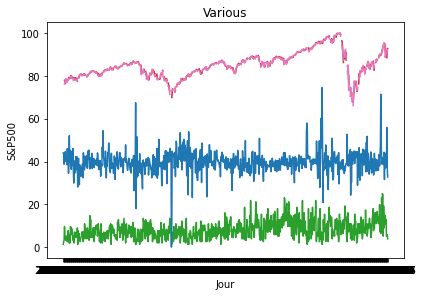

In [12]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Jour')
ax1.set_ylabel('S&P500')

color = 'tab:green'
ax1.plot(sorted_keys[2500:], tweet_count_by_date[2500:], color=color, label='Tweet count')

color = 'tab:blue'
ax1.plot(sorted_keys[2500:], average_impact_by_date[2500:], color=color, label='Average impact')

color = 'tab:red'
ax1.plot(sorted_keys[2500:], spx_open[2500:], color=color, label='SPX Open')

color = 'tab:pink'
ax1.plot(sorted_keys[2500:], spx_close[2500:], color=color, label='SPX Close')

fig.tight_layout()
plt.title('Various')
#plt.legend()
plt.show()

In [14]:
update_sql = []

for key in data_by_date.keys():
    update_sql.append('update public.trump_tweets_daily_stats set "spx_open" = {}, "spx_close" = {}, "spx_high" = {}, "spx_low" = {}, "average_impact_level" = {}, "tweet_count" = {} where "date" = \'{}\';'.format(
        data_by_date[key]['spx_open'],
        data_by_date[key]['spx_close'],
        data_by_date[key]['spx_high'],
        data_by_date[key]['spx_low'],
        data_by_date[key]['average_impact'],
        data_by_date[key]['count'],
        key
    ))

with open('../db/update_data/update_daily_stats_with_spx_normalized.csv', 'w') as output:
    output.write('\n'.join(update_sql).replace('None', 'null'))